<table style="background-color: rgb(13,32,76); border-radius: 10px">
	<thead>
		<tr>
			<th colspan="2" style="border: hidden; vertical-align: top;" width="15%"><img src="https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/1674755226__Icons_400px_Practice Assignment.png">
			</th>
			<th style="border: hidden;">
				<h1 style="color: white;">GloVe Embeddings (Practice)</h1>
			</th>
		</tr>
	</thead>
</table>
<p>This practice assignment will reinforce important learning objectives from the previous lesson(s), and allow you to take on more challenging core assignments, preparing you for graduation.<br></p>
<p>Practice and tinker with this assignment until you're comfortable performing each of the tasks. Then, be sure to submit your output as described in the steps below.</p>
<hr>
<h2>GloVe Embeddings</h2>
<h4>Instructions</h4>
<p>
</p>
<h1><span style="color: rgb(80, 80, 80); font-size: 14px; font-weight: normal;">Work with the Yelp restaurant data from the previous lessons. You should already have saved it, but <a href="https://drive.google.com/file/d/1Q0eWuSXPJg6lYofPfdrUf18zcFvljJqL/view?usp=sharing" target="_blank">here</a> it is for reference.</span></h1>
<p><br></p>
<ul><li>Make a Gensim KeyedVectors object using the GloVe.6B.300d.text file from: <a href="https://nlp.stanford.edu/projects/glove/">https://nlp.stanford.edu/projects/glove/</a>.  Note that this file was included in the glove3b.zip that we downloaded in the previous lesson.</li><li>Explore the KeyedVector object<ul><li>How many words are included?</li><li>Output the vector for the word "explore"</li><li>What is the shape of the word vector array for a single word?</li><li>Find the top 10 words that are similar to "explore" based on their vectors</li></ul></li><li>Build and train sequence vectorizer with an output sequence length of 400. Our solution used the custom make_text_vectorizaton_layer with default arguments, but feel free to explore!</li><li>Create an embedding matrix for the vocabulary words from the sequence vectorizer by looping through each word in the vocabulary and combining it with its associated GloVe vector</li><li>Create a Keras embedding layer using the embedding matrix, set the "trainable" argument to "False"<ul><li>Use embedding dimensions to match the GloVe file (300)</li></ul></li><li>Define a function to build an RNN model using the GloVe embedding layer you created in the previous step<ul><li>Choose any variation of an LSTM or GRU model you wish to try</li></ul></li><li>Build, fit, and evaluate the model</li></ul>
<p>Solution</p>
<p><br></p>
<p><br></p>

In [1]:
import tensorflow as tf
import numpy as np

# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [2]:
import pandas as pd
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

from sklearn import set_config
set_config(transform_output='pandas')

pd.set_option('display.max_colwidth', 250)

In [3]:
# You could access this function from a .py file instead of loading it here!
from pprint import pprint
def make_text_vectorization_layer(train_ds,  max_tokens=None, 
                                  split='whitespace',
                                  standardize="lower_and_strip_punctuation",
                                  output_mode="int",
                                  output_sequence_length=None,
                                  ngrams=None, pad_to_max_tokens=False,
                                  verbose=True,
                                  **kwargs,
                                 ):


    # Build the text vectorization layer
    text_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        standardize=standardize, 
        output_mode=output_mode,
        output_sequence_length=output_sequence_length,
        **kwargs
    )

    # Get just the text from the training data
    if isinstance(train_ds, (np.ndarray, list, tuple, pd.Series)):
        ds_texts = train_ds
    else:
        try:
            ds_texts = train_ds.map(lambda x, y: x )
        except:
            ds_texts = train_ds
            
    # Fit the layer on the training texts
    text_vectorizer.adapt(ds_texts)
    
    
    if verbose:
        # Print the params
        print( "\ntf.keras.layers.TextVectorization(" )
        config = text_vectorizer.get_config()
        pprint(config,indent=4)
        print(")")
               
    # SAVING VOCAB FOR LATER
    # Getting list of vocab 
    vocab = text_vectorizer.get_vocabulary()
    # Save dictionaries to look up words from ints 
    int_to_str  = {idx:word for idx, word in enumerate(vocab)}
    
    return text_vectorizer, int_to_str


In [4]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [5]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

In [6]:
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()
    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):
        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]
        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass
        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

In [7]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [8]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

# Create and Explore Keyed Vectors Object

In [9]:
from gensim.models import KeyedVectors

# Load GloVe vectors into a gensim model
glove_model = KeyedVectors.load_word2vec_format("GloVe2/glove.6B.300d.txt", binary=False, no_header=True)

In [10]:
# How many words are included?
len(glove_model)

400000

In [11]:
# You can now use `glove_model` to access individual word vectors, similar to a dictionary
vector = glove_model['explore']
vector

array([-3.7632e-01, -8.3171e-02, -5.4273e-01, -1.8057e-01,  1.0441e-01,
        2.5691e-02, -2.3151e-01, -5.2861e-01,  3.4421e-01, -1.2153e+00,
        6.3857e-02, -9.4788e-02,  1.1429e-03, -1.0277e-01, -3.6178e-01,
       -3.8062e-01,  2.5355e-02,  7.6779e-02,  1.5174e-01,  3.9350e-01,
       -2.6153e-01,  5.0544e-01, -1.8084e-01,  3.1431e-01, -1.1805e-02,
       -3.2982e-01,  2.1250e-01,  9.6717e-02, -4.1366e-01,  3.5591e-01,
        6.4419e-01,  1.9732e-02,  7.2001e-02, -4.5671e-01, -3.3544e-02,
        5.0811e-01,  2.1295e-01,  1.8652e-01,  8.7259e-02,  2.6147e-02,
        1.2163e-01,  5.4725e-01, -7.9931e-02,  3.1370e-01, -1.6159e-01,
        1.8158e-01,  1.3763e-01,  2.7857e-01, -2.7582e-01, -3.2082e-01,
        4.9341e-01, -1.5069e-01,  6.7678e-02, -3.8612e-01,  3.1652e-01,
        2.4390e-01, -6.3029e-02,  6.2480e-01, -1.4214e-01,  1.0654e-01,
        4.1776e-03,  3.3195e-01,  4.0198e-01, -9.1901e-02,  5.3655e-01,
        5.8561e-01,  1.7356e-02, -9.8689e-02, -4.6342e-01,  9.86

In [12]:
# shape of vector for a single word
vector.shape

(300,)

In [13]:
# Find similar words
glove_model.most_similar('explore', topn=10)

[('exploring', 0.8333841562271118),
 ('explored', 0.6792457103729248),
 ('possibilities', 0.6162793040275574),
 ('ways', 0.5818804502487183),
 ('exploration', 0.577148973941803),
 ('examine', 0.5751627683639526),
 ('develop', 0.563709557056427),
 ('discuss', 0.5340580344200134),
 ('explores', 0.5253989100456238),
 ('opportunities', 0.5125430822372437)]

# Build and Train a sequence vectorizer

In [14]:
# Load Data from your path
df = pd.read_csv("Data/yelp-restaurant-reviews-CA-2015-2018.csv.gz", index_col = 'date', parse_dates=['date'])
## Remove any non-english reivews
df = df.loc[ df['language']=='en'].copy()
# Keep only 1,3,5 star reviews
df = df.loc[ df['stars'].isin([1,3,5])]
# Take a smaller subset
df = df.loc['2018']
# Set the index
df = df.set_index('review_id')
# We will split on each space, and then get the length
df['sequence_length'] =df['text'].map( lambda x: len(x.split(" ")))
# Define a filter to identify reviews less than 400 words
filter_short = df['sequence_length']< 400
# Keep short reviews (<400 words)
df=  df.loc[filter_short]
# Use RUS to reduce n to match minority group
sampler = RandomUnderSampler(random_state=42)
df_ml,  _ = sampler.fit_resample(df, df['stars'])
df_ml['stars'].value_counts()
# Define X
X = df_ml['text'].values
# Create a map for targets
target_map = {1:0,
              3:1,
              5:2}
# Define y and apply the target_map
y = df_ml['stars'].map(target_map)

# Define classes variable
classes = y.unique()
classes

array([0, 1, 2], dtype=int64)

In [15]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))
# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False)

In [16]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)
# Set the batch size
BATCH_SIZE =32
import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	3880 samples 	(122 batches)
    - val:  	1108 samples 	(35 batches)
    - test: 	556 samples 	(18 batches)


In [17]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [18]:
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 122 training batches.
 There are 35 validation batches.
 There are 18 testing batches.


In [19]:
# Define sequence length as a variable for future use
SEQUENCE_LENGTH = 400
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
sequence_vectorizer, vocab_lookup = make_text_vectorization_layer(train_ds, output_mode='int', output_sequence_length = SEQUENCE_LENGTH, verbose=True)


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 400,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 13461}
)


In [20]:
vocab_size = len(sequence_vectorizer.get_vocabulary())  # Assuming `seq_vectorizer` is your TextVectorization layer
embedding_dim = 300  # use 300 for this glove model

In [21]:
# Initialize an empty matrix to hold the word embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Loop to get each word from vocabulary and get its pre-trained vector from GloVe model
for i, word in enumerate(sequence_vectorizer.get_vocabulary()):
    try:
        embedding_matrix[i] = glove_model[word]
    except KeyError:
        # If the word is not in the GloVe vocabulary, skip it
        pass

In [22]:
from tensorflow.keras.layers import Embedding
# Create the embedding layer using the embedding matrix
glove_embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            trainable=False,  # Set trainable=False to keep the embeddings fixed
                            input_length=SEQUENCE_LENGTH)

# Build an RNN using the glove_embedding layer--the model is up to you!


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

def build_model_glove(text_vectorization_layer, glove_embedding_layer):
    
    MAX_TOKENS = text_vectorization_layer.vocabulary_size()
        
    model = Sequential([
        text_vectorization_layer,
        glove_embedding_layer])
        
    # Bidirectional GRU layer
    model.add(layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True, dropout=0.2)))

    # Pooling layer
    model.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    model.add(layers.Dense(len(classes), activation='softmax'))

    # Define the optimizer
    optimizer = optimizers.legacy.Adam(learning_rate=0.01)
    # Compile the model
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [24]:
# using restore_best_weights = False 
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor, restore_best_weights=False)
    return [early_stop]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 400)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 400, 300)          4038300   
                                                                 
 bidirectional (Bidirectiona  (None, 400, 256)         330240    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                        

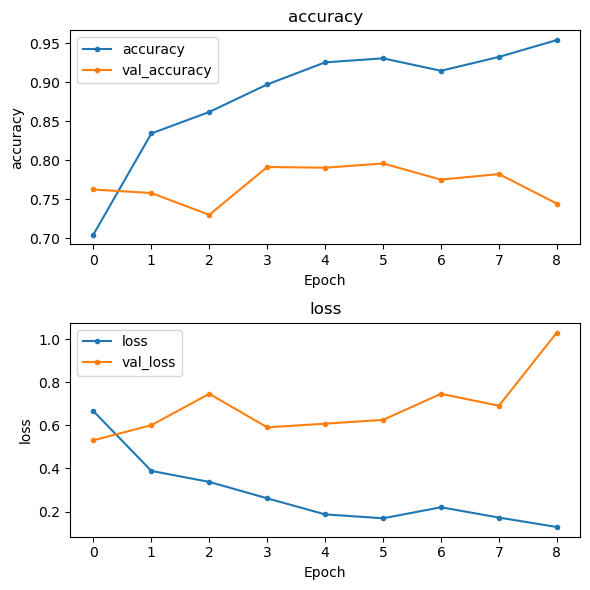


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      1274
           1       0.82      1.00      0.90      1283
           2       1.00      0.92      0.96      1323

    accuracy                           0.93      3880
   macro avg       0.94      0.93      0.93      3880
weighted avg       0.94      0.93      0.93      3880



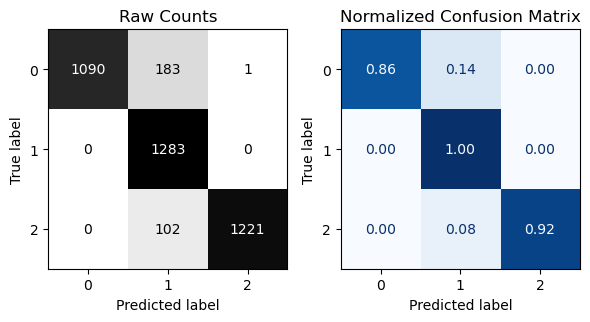


- Evaluating Training Data:
122/122 [==============================] - 24s 196ms/step - loss: 0.1743 - accuracy: 0.9263
{'loss': 0.17431703209877014, 'accuracy': 0.9262886643409729}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.63      0.73       195
           1       0.60      0.87      0.71       191
           2       0.93      0.75      0.83       170

    accuracy                           0.75       556
   macro avg       0.80      0.75      0.76       556
weighted avg       0.80      0.75      0.75       556



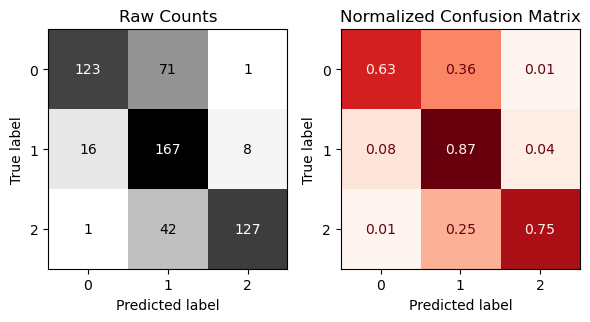


- Evaluating Test Data:
18/18 [==============================] - 3s 177ms/step - loss: 1.0139 - accuracy: 0.7500
{'loss': 1.0138806104660034, 'accuracy': 0.75}


In [25]:
# Build the model

baseline_model = build_model_glove(sequence_vectorizer,glove_embedding_layer)

EPOCHS = 100
# Fit the mdoel
history = baseline_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the mdoel
results = evaluate_classification_network(
    baseline_model, X_train=train_ds, 
    X_test=test_ds, history=history,
);